In [1]:
import Zygote: @ignore_derivatives
import Optimisers
import Zygote
import Plots
import CSV
import Random
import GLM
using Lux
using DataFrames
using ComponentArrays
using PartialFunctions
using SciMLSensitivity
using DifferentialEquations
using JLD2
using Printf

include("../../../DCM/src/lib/population.jl");
include("../../../DCM/src/lib/model.jl");
include("../../../DCM/src/lib/error.jl");
include("../../../DCM/src/lib/objectives.jl");
include("../../../DCM/src/lib/compartment_models.jl");
include("../../../DCM/src/lib/callbacks.jl");
include("../../../DCM/src/lib/constrain.jl");
include("../../../DCM/src/lib/lux.helpers.jl");
include("../../../DCM/src/lib/dcm.jl");

## Data preparation

In [2]:
# Read Data
file = "../../data/fviii_sim.csv"
df = CSV.read(file, DataFrame)

# One dataframe per patient
df_group = groupby(df, :id);

In [3]:
# Create population
function create_population(df_group_inds)
    indvs = Vector{AbstractIndividual}(undef, length(df_group_inds))
    for (i, group) in enumerate(df_group_inds)
        x = Vector{Float32}(group[1, [:weight, :age]])
        ty = group[(group.mdv .== 0), [:t, :dv]]
        𝐈 = Matrix{Float32}(group[group.mdv .== 1, [:t, :amt, :rate, :duration]])
        callback = generate_dosing_callback(𝐈)
        indvs[i] = Individual(x, Float32.(ty.t), Float32.(ty.dv), callback; id = group.id[1])
    end
    return Population(indvs);
end
population = create_population(df_group);

## Training

### Functions

In [15]:
# Create neural network architecture
function dnn()
    return Chain(
        Normalize([70, 40]),
        Dense(2, 16, swish), 
        Dense(16, 8, swish),
        Dense(8, 4, softplus), 
    )
end

# Train
function train_model(model, population_train, num_epochs; population_test=nothing, verbose=true, patience=100, tol=0.01)
    global opt_state
    losses = []
    losses_test = []
    times = []

    count = 0
    for epoch in 1:num_epochs
        elapsed_time = @elapsed begin
            loss, back = Zygote.pullback(p -> objective(model, population_train, p), model.p)
            grad = first(back(1))
            opt_state, p = Optimisers.update(opt_state, model.p, grad)
            update!(model, p)
        end
        push!(times, elapsed_time)

        push!(losses, loss)
        if population_test !== nothing
            push!(losses_test, objective(model, population_test, model.p))
        end

        if (epoch == 1 || epoch % 50 == 0) && verbose
            println("Epoch $epoch, loss = $loss")
        end

        if epoch == 500      
            Optimisers.adjust!(opt_state, 0.001)
        end

        # Early stopping on percentual change of test loss. The test population is needed
        if population_test !== nothing
            if (epoch > 1) && ((losses_test[end-1] - losses_test[end])/losses_test[end-1] < tol)
                count += 1
                if count == patience
                    println("Early stopped. Percentual test loss did not improve at least $tol for $patience epochs. Trained for $epoch epochs\n")
                    verbose && println("\nMean ± std training time per epoch: $(@sprintf("%.2e", mean(times))) ± $(@sprintf("%.2e", std(times))) seconds")
                    return model, losses, losses_test
                end
            else 
                count = 0
            end
        end

    end
    verbose && println("\nMean ± std training time per epoch: $(@sprintf("%.2e", mean(times))) ± $(@sprintf("%.2e", std(times))) seconds")
    return model, losses, losses_test
end

# MAE
function mae(model, population)
    ŷ = predict(model, population; interpolate=false)[1]
    ŷ = map(x -> x.u, ŷ)
    dif = reduce(vcat, population.y - ŷ)
    return sum(abs, dif)/length(dif)
end


# Plot predictions vs real values
function plot_predictions_real(model, population; threshold=0.2)
    real = reduce(vcat, population.y)
    preds, st = predict(model, population; interpolate=false)
    predicted = reduce(vcat, map(x -> x.u, preds))

    plt = Plots.scatter(
        real,
        predicted,
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:blue,
        size=(600,400),
        legend=false
    )

    lr = GLM.lm(GLM.@formula(y ~ X), DataFrame(X=Float64.(real), y=Float64.(predicted)))

    accuracy = count(x -> x < threshold, abs.((real - predicted)) ./ (real .+ 1e-6))/length(real)
    max_value = ceil(maximum(vcat(real, predicted)))
    Plots.plot!(plt, 
        [0, max_value], 
        [0, max_value],
        #ribbon = [0, max_value] .* threshold,
        fillalpha = 0.2,
        #color = "red",
        linestyle = :dash,
        
        )

    regression = GLM.predict(lr, DataFrame(X=[0, max_value]))
    rsquared = GLM.r2(lr)

    Plots.plot!(plt, 
        [0, max_value], 
        regression,
        color = "blue",
        title = "R2 = $(@sprintf("%.2f", rsquared))"
        )
    display(plt)
end

function training_metrics(model, population)
    #MAE
    mean_absolute_error = mae(model, population)

    #R2
    real = reduce(vcat, population.y)
    preds, st = predict(model, population; interpolate=false)
    predicted = reduce(vcat, map(x -> x.u, preds))
    lr = GLM.lm(GLM.@formula(y ~ X), DataFrame(X=Float64.(real), y=Float64.(predicted)))
    rsquared = GLM.r2(lr)

    return mean_absolute_error, rsquared
end


# Plot predictions vs real values
function plot_train_test_real(model, population_train, population_test)
    real = reduce(vcat, population_train.y)
    preds, st = predict(model, population_train; interpolate=false)
    predicted = reduce(vcat, map(x -> x.u, preds))

    plt = Plots.scatter(
        real, 
        predicted,
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:blue,
        size=(600,400),
        label="Train"
    )

    real = reduce(vcat, population_test.y)
    preds, st = predict(model, population_test; interpolate=false)
    predicted = reduce(vcat, map(x -> x.u, preds))

    Plots.scatter!(
        real, 
        predicted,
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:red,
        size=(600,400),
        label="Test"
    )

    max_value = ceil(maximum(reduce(vcat, population_train.y)))
    Plots.plot!(plt, 
        [0, max_value], 
        [0, max_value],
        linestyle = :dash,
        color=:black,
        label=nothing
        )
    display(plt)
end

plot_train_test_real (generic function with 1 method)

### Train using all the population

Epoch 1, loss = 307739.72
Epoch 50, loss = 3195.271
Epoch 100, loss = 1430.314
Epoch 150, loss = 1130.6532
Epoch 200, loss = 930.5158
Epoch 250, loss = 798.0266
Epoch 300, loss = 722.2191
Epoch 350, loss = 686.65
Epoch 400, loss = 670.2023
Epoch 450, loss = 659.4562
Epoch 500, loss = 649.7969
Epoch 550, loss = 648.65405
Epoch 600, loss = 647.6587

Mean ± std training time per epoch: 5.44e-02 ± 1.61e-02 seconds

Final MSE: 647.6587
Final MAE: 5.136739
Final R2: 0.8761054565168833


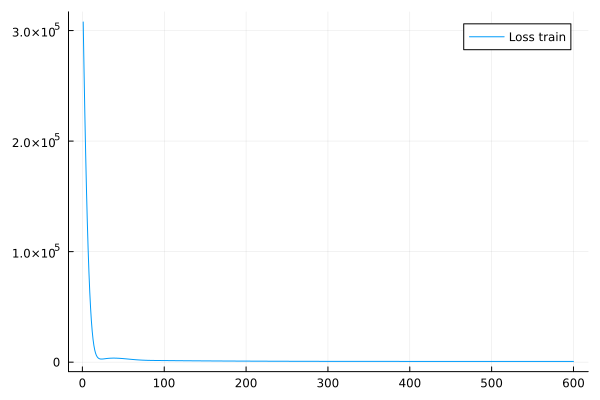

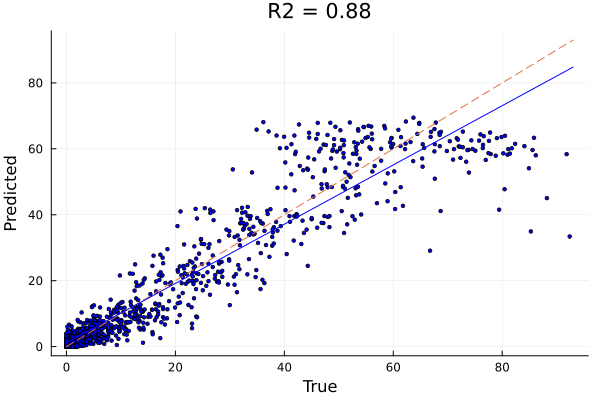

In [25]:
ann = dnn()
model = DCM(two_comp_abs!, 3, ann; dv_compartment=2)

opt = Optimisers.ADAM(1e-2)
opt_state = Optimisers.setup(opt, model.p)

model, losses, _ = train_model(model, population, 600)

println()
final_mse = losses[end]
println("Final MSE: $final_mse")

final_mae, final_r2 = training_metrics(model, population)

println("Final MAE: $final_mae")
println("Final R2: $final_r2")

plt = Plots.plot(losses, label = "Loss train")
display(plt)

plot_predictions_real(model, population)

### Save/load model

In [26]:
# Save model
# jldsave("models/mymodel-fviii-5.jld2"; model)

In [5]:
# Load model
# mymodel = JLD2.load("mymodel.jld2")
# model = mymodel["model"]

DeepCompartmentModel{two_comp_abs!, SSE}

### Train using test split

Epoch 1, loss = 279903.75
Epoch 50, loss = 3117.6782
Epoch 100, loss = 1047.0537
Epoch 150, loss = 768.0428
Epoch 200, loss = 690.0932
Epoch 250, loss = 660.77155
Epoch 300, loss = 647.43414
Epoch 350, loss = 638.77356
Early stopped. Percentual test loss did not improve at least 0.001 for 100 epochs. Trained for 364 epochs


Mean ± std training time per epoch: 9.47e-02 ± 2.99e-02 seconds



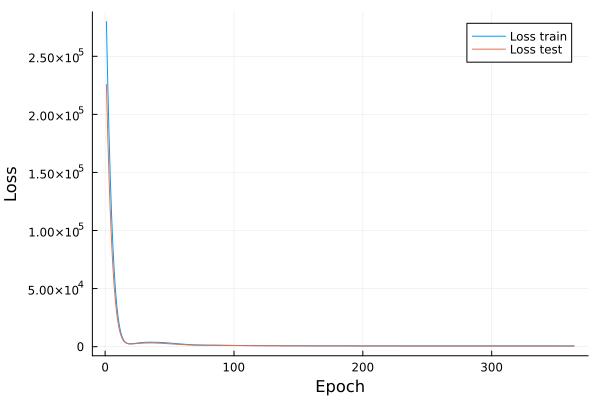


Final MAE train: 4.954663
Final R2 train: 0.8818298164163435

Final MAE test: 4.8179245
Final R2 test: 0.8947775850175724


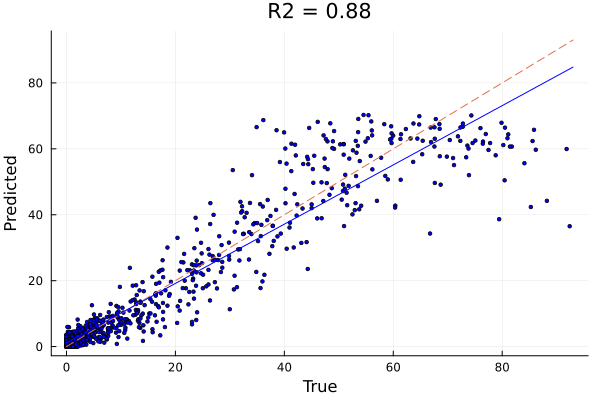

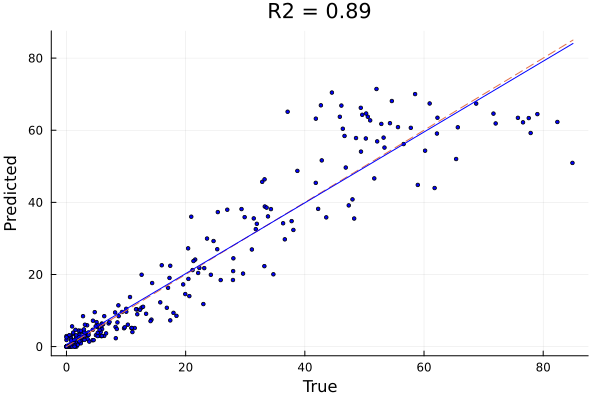

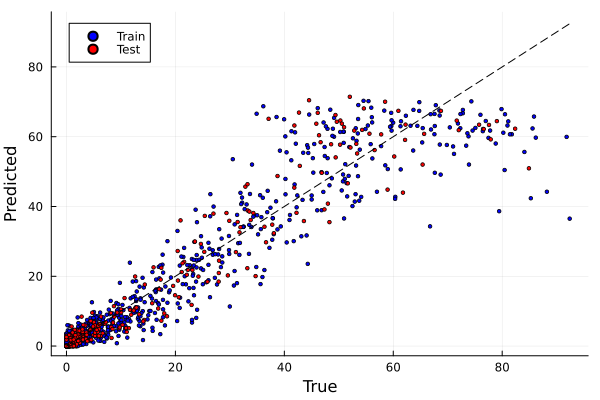

In [18]:
# Get random patients for train and test
Random.seed!(10)
ids = 1:length(df_group)
test_ids = sample(ids, div(length(ids), 4), replace = false)
train_ids = setdiff(ids, test_ids)

# Create train and test populations
population_test = create_population(df_group[test_ids]);
population_train = create_population(df_group[train_ids]);

ann = dnn()
model = DCM(two_comp_abs!, 3, ann; dv_compartment=2)

opt = Optimisers.ADAM(1e-2)
opt_state = Optimisers.setup(opt, model.p)

model, losses, losses_test = train_model(model, population_train, 1_000; population_test=population_test, patience=100, tol=0.001)

println()
plt = Plots.plot(losses, label = "Loss train", xlabel="Epoch", ylabel="Loss")
Plots.plot!(plt, losses_test, label = "Loss test")
display(plt)

println()
final_mae_train, final_r2_train = training_metrics(model, population_train)
println("Final MAE train: $final_mae_train")
println("Final R2 train: $final_r2_train")
println()
final_mae_test, final_r2_test = training_metrics(model, population_test)
println("Final MAE test: $final_mae_test")
println("Final R2 test: $final_r2_test")

plot_predictions_real(model, population_train)
plot_predictions_real(model, population_test)
plot_train_test_real(model, population_train, population_test)

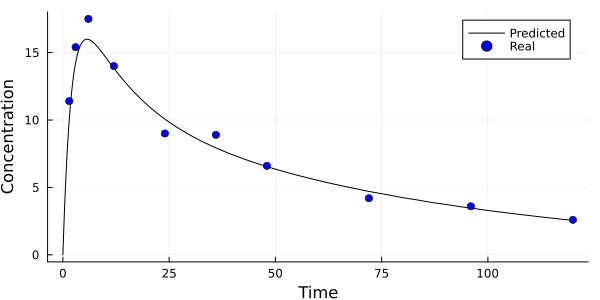

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/DCM/results/overfit.png"

In [107]:
predict_real_individual(population[10], model2; max_time = 120, plot_predictions = true, plot_true_labels = true);
#Plots.savefig("./results/overfit.png")

### K folds training

In [14]:
# Get random patients for train and test
folds = 7
ids = 1:length(df_group)

l_mae_train = []
l_mae_test = []
l_r2_train = []
l_r2_test = []

for i in 1:folds
    println("Fold $i/$folds")
    test_ids = sample(ids, div(length(ids), 4), replace = false)
    train_ids = setdiff(ids, test_ids)

    # Create train and test populations
    population_test = create_population(df_group[test_ids]);
    population_train = create_population(df_group[train_ids]);

    ann = dnn()
    model = DCM(two_comp_abs!, 3, ann; dv_compartment=2)
    
    opt = Optimisers.ADAM(1e-2)
    opt_state = Optimisers.setup(opt, model.p)
    
    model, _, _ = train_model(model, population_train, 1000; population_test=population_test, verbose=false, patience=50, tol=0.001)

    final_mae_train, final_r2_train = training_metrics(model, population_train)
    push!(l_mae_train, final_mae_train)
    push!(l_r2_train, final_r2_train)

    final_mae_test, final_r2_test = training_metrics(model, population_test)
    push!(l_mae_test, final_mae_test)
    push!(l_r2_test, final_r2_test)
end

# Remove largest and smallest values from list. To remove extreme cases that can happen due to initialization
l_mae_train = filter(x -> x != maximum(l_mae_train) && x != minimum(l_mae_train), l_mae_train)
l_mae_test = filter(x -> x != maximum(l_mae_test) && x != minimum(l_mae_test), l_mae_test)
l_r2_train = filter(x -> x != maximum(l_r2_train) && x != minimum(l_r2_train), l_r2_train)
l_r2_test = filter(x -> x != maximum(l_r2_test) && x != minimum(l_r2_test), l_r2_test)

println()
println("Mean ± std MAE train: $(@sprintf("%.2f", mean(l_mae_train))) ± $(@sprintf("%.2f", std(l_mae_train)))")
println("Mean ± std MAE test: $(@sprintf("%.2f", mean(l_mae_test))) ± $(@sprintf("%.2f", std(l_mae_test)))")
println()
println("Mean ± std R2 train: $(@sprintf("%.2f", mean(l_r2_train))) ± $(@sprintf("%.2f", std(l_r2_train)))")
println("Mean ± std R2 test: $(@sprintf("%.2f", mean(l_r2_test))) ± $(@sprintf("%.2f", std(l_r2_test)))")

Fold 1/7
Early stopped. Percentual test loss did not improve at least 0.001 for 50 epochs. Trained for 192 epochs

Fold 2/7
Early stopped. Percentual test loss did not improve at least 0.001 for 50 epochs. Trained for 187 epochs

Fold 3/7
Early stopped. Percentual test loss did not improve at least 0.001 for 50 epochs. Trained for 501 epochs

Fold 4/7
Early stopped. Percentual test loss did not improve at least 0.001 for 50 epochs. Trained for 201 epochs

Fold 5/7
Early stopped. Percentual test loss did not improve at least 0.001 for 50 epochs. Trained for 297 epochs

Fold 6/7
Early stopped. Percentual test loss did not improve at least 0.001 for 50 epochs. Trained for 308 epochs

Fold 7/7
Early stopped. Percentual test loss did not improve at least 0.001 for 50 epochs. Trained for 366 epochs


Mean ± std MAE train: 1.42 ± 0.14
Mean ± std MAE test: 1.61 ± 0.34

Mean ± std R2 train: 0.75 ± 0.05
Mean ± std R2 test: 0.68 ± 0.08


### Train for just a few epochs

Epoch 1, loss = 21446.63
Epoch 100, loss = 1297.7024
Epoch 200, loss = 1004.1682

Mean ± std training time per epoch: 1.44e-02 ± 8.78e-03 seconds

Final SSE: 1004.1682
Final MAE: 1.4899287


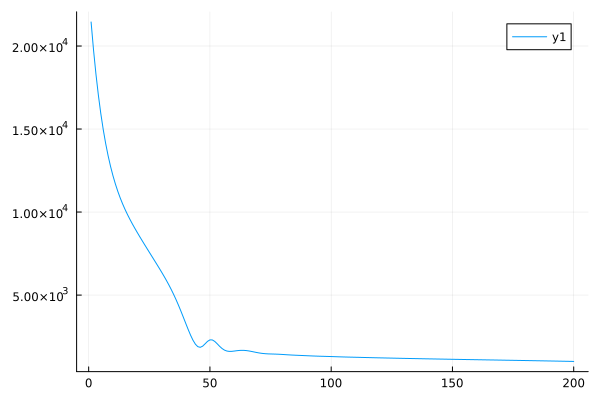

In [170]:
ann = dnn()
model3 = DCM(two_comp_abs!, 3, ann; dv_compartment=2)

opt = Optimisers.ADAM(1e-2)
opt_state = Optimisers.setup(opt, model3.p)

model3, losses, _ = train_model(model3, population, 200)

println()
final_sse = losses[end]
println("Final SSE: $final_sse")

final_mae = mae(model3, population)
println("Final MAE: $final_mae")

Plots.plot(losses)

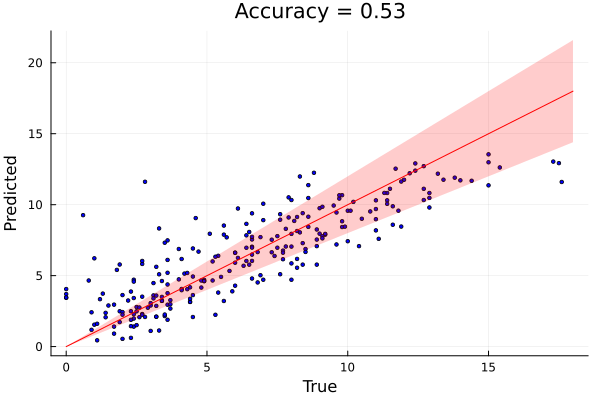

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/DCM/results/10p_epochs_acc.png"

In [173]:
plot_predictions_real(model3, population; threshold=0.2)
#Plots.savefig("./results/10p_epochs_acc.png")


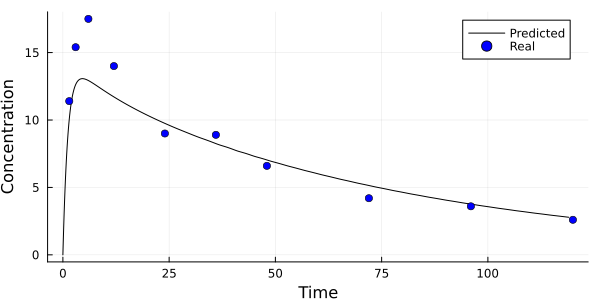

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/DCM/results/10p_epochs.png"

In [174]:
predict_real_individual(population[10], model3; max_time = 120, plot_predictions = true, plot_true_labels = true);
Plots.savefig("./results/10p_epochs.png")


## Predict

### Functions

In [13]:
# Predict a single individual. The predicted values are only saved for the individual.t times
function predict_individual(individual, model; plot_predictions=false)

    predicted, st = predict(model, individual; interpolate=false);

    if plot_predictions
        plt = Plots.plot(predicted.t, predicted.u, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        display(plt)
    end
    return predicted
end

# Predict a single real individual with labels. The predicted values are saved for all the times between 0 and max_time but the real labels are plotted for the real times
function predict_real_individual(individual, model; max_time = 120, plot_predictions = false, plot_true_labels = false)

    time_real = individual.t
    real_y = individual.y

    time = collect(0:0.1:(max_time-1));
    subject = Individual(individual.x, Float32.(time), Float32.(zeros(length(time))), individual.callback);

    predicted, st = predict(model, subject; interpolate=false);

    if plot_predictions
        plt = Plots.plot(predicted.t, predicted.u, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        if plot_true_labels
            Plots.scatter!(plt, time_real, real_y, label="Real", color=:blue)
        end
        display(plt)
    end
    return predicted, time
end


# Create Intervention Matrix from [(time1, dose1), (time2, dose2), ...] list
function create_intervention_matrix(dose_list; duration = 120)
    if length(dose_list) == 0 return end
    M = []
    for (t, d) in dose_list
        row = [t, d, d * duration, 1/duration]
        push!(M, row)
    end

    # Convert the array of arrays to a matrix
    M = hcat(M...)
    M = M'
end

create_intervention_matrix (generic function with 1 method)

### Predict real individual from population with real labels

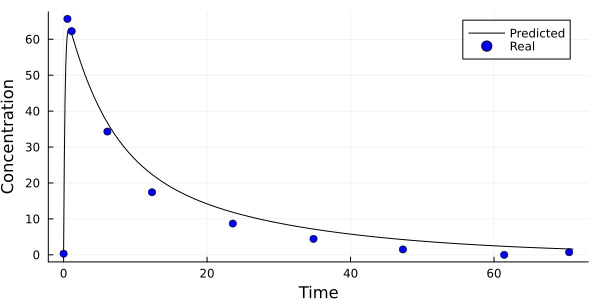

In [46]:
#predict_real_individual(population[10], model; max_time = 120, plot_predictions = true, plot_true_labels = true);
#Plots.savefig("./results/discontinuity.png")

predict_real_individual(population[3], model; max_time = 72, plot_predictions = true, plot_true_labels = true);
#Plots.savefig("./results/fit_large_values.png");

### Predict single individual without labels

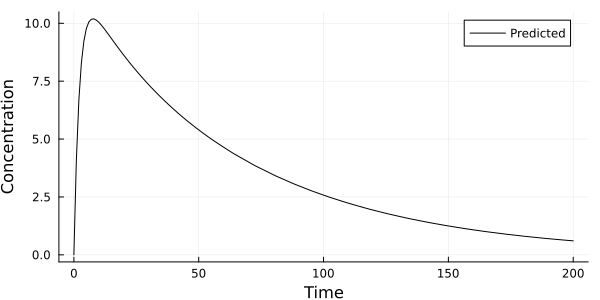

In [17]:
t = collect(0:1:200)
x = [70.0, 40.0, 1]

doses = [(0,100)] # (Time, Dose)
I = create_intervention_matrix(doses)
callback = generate_dosing_callback(I)

subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), callback)
#subject = population[8]

predict_individual(subject, model; plot_predictions=true);

## Experiments

### Functions

In [21]:
function test_variables(ind, model; variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])
    colors = Plots.palette(:rainbow, length(values))

    #t = collect(0:1:200)
    cback = ind.callback
    x = copy(ind.x)
    t = copy(ind.t)

    plt = Plots.plot(label="Predicted", xlabel="Time", ylabel="Concentration", size=(600,300))
    for (i, val) in enumerate(values)
        if variable == "AMT"
            I = create_intervention_matrix([(0.0, val)])
            cback = generate_dosing_callback(I)
        elseif variable == "WEIGHT"
            x[1] = val
        elseif variable == "AGE"
            x[2] = val
        elseif variable == "SEX"
            x[3] = val
        else
            error("Variable not found")
        end

        test_ind = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), cback)

        predicted = predict_individual(test_ind, model; plot_predictions=false);
        Plots.plot!(predicted.t, predicted.u, linewidth=1, label="$variable=$val", linecolor=colors[i])
    end
    display(plt)
end

test_variables (generic function with 1 method)

### Initialize individual

In [130]:
t = collect(0:1:120)
x = [70.0, 40.0, 0]

doses = [(0,100)] # (Time, Dose)
I = create_intervention_matrix(doses)
callback = generate_dosing_callback(I)

subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), callback);

### Change AMT

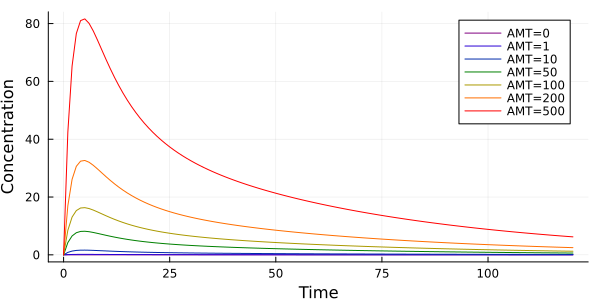

In [75]:
test_variables(subject, model; variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])
# Plots.savefig("./results/amt.png")

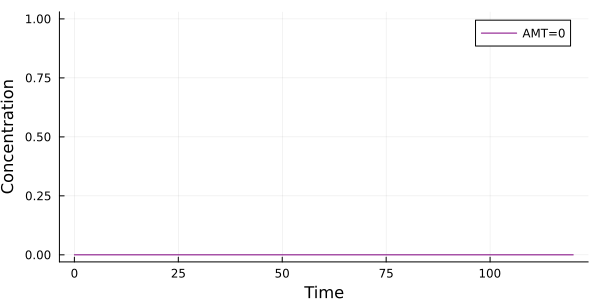

In [58]:
test_variables(subject, model; variable="AMT", values=[0])
# Plots.savefig("./results/amt0.png")

### Change Weight

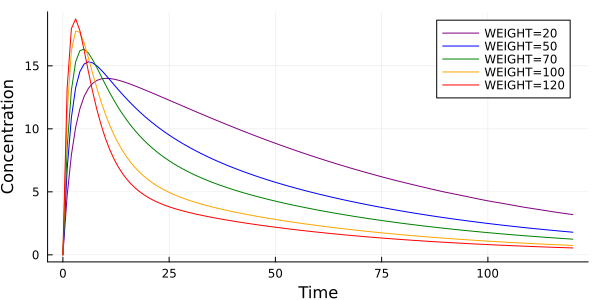

In [76]:
test_variables(subject, model; variable="WEIGHT", values=[20, 50, 70, 100, 120])
# Plots.savefig("./results/weight.png")

### Change Age

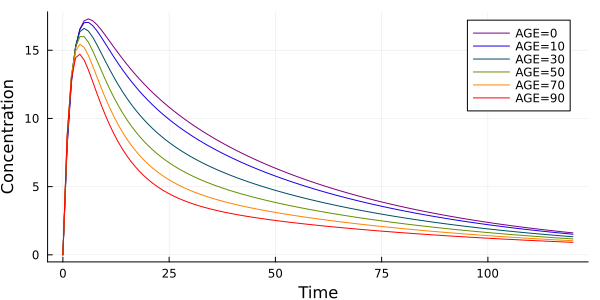

In [77]:
test_variables(subject, model; variable="AGE", values=[0, 10, 30, 50, 70, 90])
# Plots.savefig("./results/age.png")

### Change sex

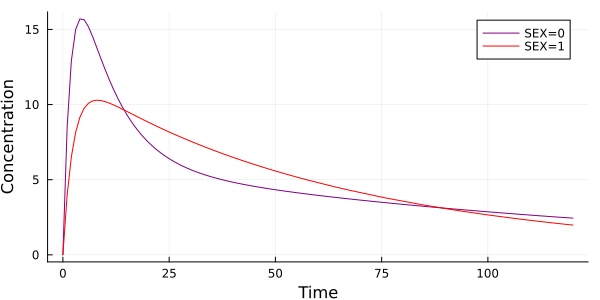

In [131]:
test_variables(subject, model3; variable="SEX", values=[0, 1])
# Plots.savefig("./results/sex.png")

### Simulate long time 

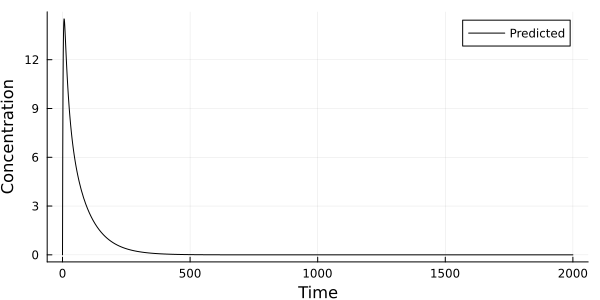

retcode: Success
Interpolation: 1st order linear
t: 2001-element Vector{Float32}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 1992.0
 1993.0
 1994.0
 1995.0
 1996.0
 1997.0
 1998.0
 1999.0
 2000.0
u: 2001-element Vector{Float32}:
  0.0
  6.2844634
 10.130229
 12.397218
 13.659243
 14.284783
 14.510421
 14.487521
 14.313078
 14.049171
  ⋮
  1.6331917f-7
 -1.0826063f-7
 -3.5311004f-7
 -3.7032524f-7
 -2.252117f-7
 -1.2864025f-7
 -8.191139f-8
 -6.930922f-8
 -5.8117756f-8

In [79]:
t = collect(0:1:2000)
x = [70.0, 40.0, 1]

doses = [(0,100)] # (Time, Dose)
I = create_intervention_matrix(doses)
callback = generate_dosing_callback(I)

subject = population[10];
x = copy(subject.x)
subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), subject.callback);
predict_individual(subject, model; plot_predictions=true);
# Plots.savefig("./results/long_time.png")